In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import odeint
import imageio

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags

m = 64
n = m * m
dx = (10 - (-10)) / (m)

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1)) 

e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m + 1):
    e2[m * j - 1] = 0
    e4[m * j - 1] = 1

e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n - 1]
e3[0] = e2[n - 1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n - 1]
e5[0] = e4[n - 1]

e6 = np.copy(e5)
diagonals_A = [
    e1.flatten(), e1.flatten(), e5.flatten(),
    e2.flatten(), -4 * e1.flatten(), e3.flatten(),
    e4.flatten(), e1.flatten(), e1.flatten()
]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
A = spdiags(diagonals_A, offsets_A, n, n).toarray() / dx**2

diagonals_B = [
    -1 * e1.flatten(), 1 * e1.flatten(), 1 * e1.flatten(),
    -1 * e1.flatten()
]
offsets_B = [-m, m, -n + m, n - m]
B = spdiags(diagonals_B, offsets_B, n, n).toarray() / (2*dx)


diagonals_C = [-1 * e2.flatten(), 1 * e3.flatten(), 1 * e5.flatten(), -1 * e4.flatten()]
offsets_C = [-1, 1, -m + 1, m - 1]
C = spdiags(diagonals_C, offsets_C, n, n).toarray() / (2*dx)


In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import imageio

# Define parameters
tspan = np.arange(0, 4.5, 0.5)
nu = 0.001
nx, ny = 64, 64
N = nx * ny

# Define spatial domain and initial condition
Lx, Ly = 20, 20
x2 = np.linspace(-Lx/2, Lx/2, nx+1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny+1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)
w = np.exp(-X**2 - (1/20)*Y**2).reshape(N)  # Flatten initial condition

# Define the ODE system
def spc_rhs(t, w, A, B, C, nu):
    psi = np.linalg.solve(A, w)  # Solve Poisson equation: Aψ = w
    wx = B.dot(w)  # ∂x w
    wy = C.dot(w)  # ∂y w
    psix = B.dot(psi)  # ∂x ψ
    psiy = C.dot(psi)  # ∂y ψ
    nonlinear_term = psix * wy - psiy * wx
    rhs = nu * (A.dot(w)) - nonlinear_term
    return rhs

# Solve the ODE
solution = solve_ivp(
    spc_rhs, 
    t_span=(tspan[0], tspan[-1]), 
    y0=w, 
    t_eval=tspan, 
    args=(A, B, C, nu),
    method='RK45'  # Default method, but can choose others like 'RK23', 'BDF', etc.
)

# Extract the solutions at the time points
solutions = solution.y.T

In [ ]:
# Generate frames and save as a GIF using imageio
frames = []
for j, solution in enumerate(solutions):
    fig, ax = plt.subplots()
    cax = ax.pcolor(x, y, solution.reshape(64,64), shading='auto', cmap='viridis')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'Time: {tspan[j]}')
    plt.tight_layout()

    # Save the current frame to a temporary file
    filename = f'temp_frame_{j}.png'
    plt.savefig(filename)
    frames.append(imageio.imread(filename))
    plt.close(fig)

# Save all frames as a GIF
imageio.mimsave('vorticity_evolution.gif', frames, fps=2)

print("GIF saved as 'vorticity_evolution.gif'")

# Cleanup temporary files
import os
for j in range(len(tspan)):
    os.remove(f'temp_frame_{j}.png')

C:\Users\jackr\AppData\Local\Temp\ipykernel_32340\1364547501.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


GIF saved as 'vorticity_evolution.gif'


C:\Users\jackr\AppData\Local\Temp\ipykernel_32340\437116268.py:3: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, solutions[j].reshape(64,64), shading='interp')


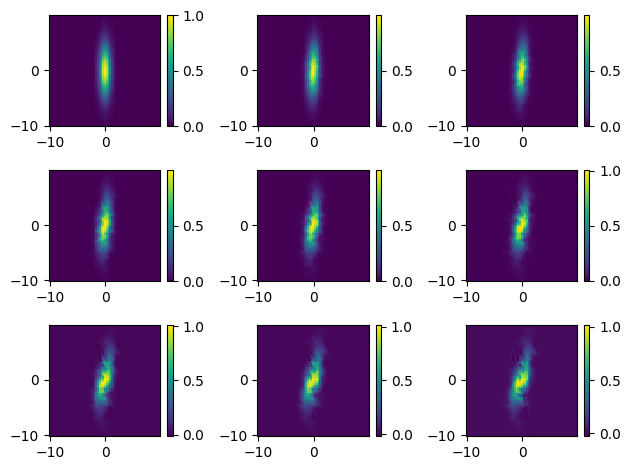

In [87]:
for j in range(9):
    plt.subplot(3, 3, j+1)
    plt.pcolor(x, y, solutions[j].reshape(64,64), shading='interp')
    plt.colorbar()

plt.tight_layout()
plt.show()